In [7]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [8]:
def kernel(x, x_prime, sigma=1, l=1, T=0.5):
    expo = - 2/l**2 * np.sin(np.pi * np.abs(x-x_prime)/T)**2
    return sigma**2 * np.exp(expo)

def kernel_cov(x, x_prime, sigma=1, l=1, T=0.5):
    cov_mtx = np.zeros((x.shape[0],x_prime.shape[0]))
    for i, ex in enumerate(x):
        for j, ex_prime in enumerate(x_prime):
            cov_mtx[i,j] = kernel(ex, ex_prime, sigma, l, T)
    return cov_mtx

def data_cov(x, x_prime, sigma=1, l=1, T=0.5, nugget_sigma=0.01):
    cov_mtx = np.zeros((x.shape[0],x_prime.shape[0]))
    for i, ex in enumerate(x):
        for j, ex_prime in enumerate(x_prime):
            cov_mtx[i,j] = kernel(ex, ex_prime, sigma, l, T)
    return cov_mtx + nugget_sigma**2 * np.eye(x.shape[0])

def prior(x, x_prime, sigma=1, l=1, T=0.5):
    cov = kernel_cov(x, x_prime, sigma, l, T)
    return np.random.multivariate_normal(np.zeros_like(x),cov = cov)

def GP(x, data, sigma=1, l=1, T=0.5, nugget_sigma=0.01):
    x_data = data[0]
    y_data = data[1]

    K_data_inv = np.linalg.inv(data_cov(x_data, x_data, sigma, l, T, nugget_sigma))

    mean = kernel_cov(x, x_data, sigma, l, T) @ K_data_inv @ y_data
    cov = kernel_cov(x, x, sigma, l, T) - kernel_cov(x, x_data, sigma, l, T) @ K_data_inv @ kernel_cov(x_data, x, sigma, l, T)
    return mean, cov

def GP_chol(x, data, sigma=1, l=1, T=0.5, nugget_sigma=0.01):
    x_data = data[0]
    y_data = data[1]

    L = np.linalg.cholesky(data_cov(x_data, x_data, sigma, l, T, nugget_sigma))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L,y_data))

    point_means = np.zeros_like(x)
    point_vars = np.zeros_like(x)
    for i,ex in enumerate(x):
        k = kernel_cov(x_data, np.array([ex]), sigma, l, T)
        v = np.linalg.solve(L,k)
        var = kernel(ex, ex, sigma, l, T) - v.T @ v

        point_means[i] = k.T @ alpha
        point_vars[i] = var

    return point_means, point_vars

data = np.array([[0, 0.2, 0.4, 0.6, 0.8, 1],
                 [0, 0.59, -0.95, 0.95, -0.59, 0]])

In [9]:
# get data for prior plotting
evals = 100
x = np.linspace(0,1,evals)
k_eval = np.zeros((evals, evals))

for i, ex in enumerate(x):
    for j, ex_prime in enumerate(x):
        k_eval[i,j] = kernel(ex, ex_prime)

# run GP
mean, cov = GP(x, data)

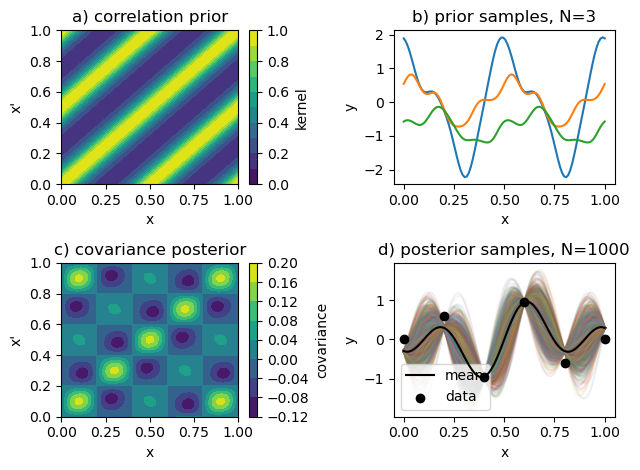

In [10]:
fig, axs = plt.subplots(2,2)


X, X_prime = np.meshgrid(x,x)
levels = np.linspace(0, 1, 11)
prior_plot = axs[0,0].contourf(X, X_prime, k_eval, levels =levels)
plt.colorbar(prior_plot, ax=axs[0,0], label='kernel')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('x\'')
axs[0,0].set_title('a) correlation prior')

for _ in range(3):
    axs[0,1].plot(x, prior(x,x))
axs[0,1].set_title('b) prior samples, N=3')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')

post_plot = axs[1,0].contourf(X, X_prime, cov)
plt.colorbar(post_plot, ax=axs[1,0], label = 'covariance')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('x\'')
axs[1,0].set_title('c) covariance posterior')


for i in range(1000):
    axs[1,1].plot(x, np.random.multivariate_normal(mean,cov), alpha = 0.1)

axs[1,1].plot(x,mean, color = 'k', label = 'mean', zorder=i+1)
axs[1,1].scatter(data[0],data[1], color='k', zorder=i+2, label='data')
axs[1,1].legend(loc = 'lower left')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1,1].set_title('d) posterior samples, N=1000')

plt.tight_layout()
plt.savefig('prior_post.png', dpi = 300)

In [11]:
# run Cholesky GP
mean_chol, var_chol = GP_chol(x, data)
std2_chol = 2*np.sqrt(var_chol)

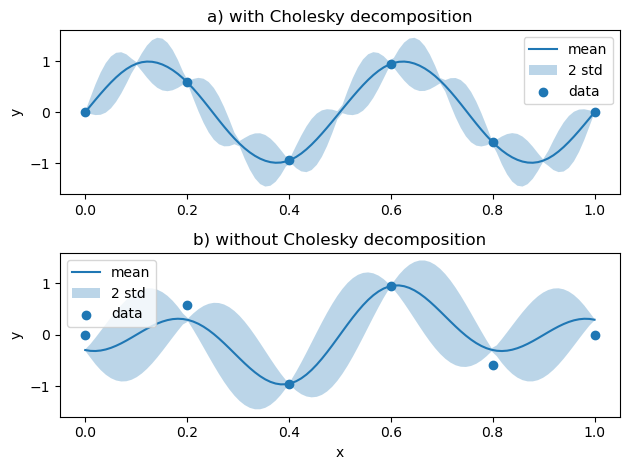

In [12]:
fig, axs = plt.subplots(2,1)
axs[0].plot(x,mean_chol, label = 'mean')
axs[0].fill_between(x, mean_chol-std2_chol, mean_chol+std2_chol, alpha = 0.3, label = '2 std')
axs[0].scatter(data[0],data[1], label='data', color = 'C0')
axs[0].legend()
axs[0].set_title('a) with Cholesky decomposition')
axs[0].set_ylabel('y')

axs[1].plot(x,mean, label = 'mean')
std2 = 2*np.sqrt(np.diag(cov))
axs[1].fill_between(x, mean-std2, mean+std2, alpha = 0.3, label = '2 std')
axs[1].scatter(data[0],data[1], label='data', color = 'C0')
axs[1].legend()
axs[1].set_title('b) without Cholesky decomposition')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.savefig('cholesky.png', dpi = 300)